# 2022-2 정보시스템보안
##Project 1: Network intrusion detection system

**Goals**

  : Implement a network intrusion detection system (AI model) using the provided network traffic 
training dataset, and detect the attack flow in the test dataset.

**모델 소개**

- 탐지 방법 : Anomaly Detection
    - Anomaly Detection(이상 탐지) : 데이터에서 예상과는 다른 패턴을 보이는 개체 또는 자료를 찾는 것
- 학습 방법 :  Unsupervised Learning - Auto Encoding 방식
    - Unsupervised Learning : Label이 없을 때 비슷한 특징끼리 군집화 하여 새로운 데이터에 대한 결과를 예측
- 모델 선정 이유 및 활용 방식
    
    - 과제에서 training set으로 주어진 정상 데이터량이 비정상 데이터량에 비해 압도적으로 많아 정상 데이터의 특성을 학습시키는 것이 더 유리하다고 판단함.(정상 데이터만을 가지고 학습시켜 labeling을 따로 하지 않음)
    - 시계열 데이터이므로, input을 순차적으로 적용하는 LSTM을 이용

  **--> LSTM-AutoEncoder Model 사용**

    
- Auto Encoder : Unsupervised Anomaly Detection의 한 종류
    - 동작 원리
        
        1) Encoding : 입력된 데이터 압축 (차원 축소)
        2) Decoding: 최대한 입력 데이터에 가깝게 학습된 인코딩 표현에서 입력 데이터를 생성
        
        정상 샘플인 경우 input값과 ouput값이 거의 동일하지만, 비정상 샘플일 경우 다르게 나오기 때문에 탐지 시스템 방식으로 적합

In [ ]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 필요 packages를 import

import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import csv

import os
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
from PIL import Image
from torchvision import models
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import natsort

In [ ]:
## GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# tensorflow의 버전이 2.X 이상인지 확인
tf.__version__

'2.8.2'

## DATA LOAD

In [ ]:
#data file upload
directory_path = '/content/drive/MyDrive/정시보 정상 파일들/'
file_list = natsort.natsorted(os.listdir(directory_path))
#train_size=int(len(file_list)*0.8)
train_list=file_list[:5]
valid_list=file_list[5:7]

Train_data=pd.DataFrame()
Valid_data=pd.DataFrame()

for x in train_list:
  add=pd.read_csv(directory_path+x,usecols=[x for x in range(12)],low_memory=False)
  Train_data=pd.concat([Train_data,add],ignore_index=True)
for x in valid_list:
  add=pd.read_csv(directory_path+x,usecols=[x for x in range(12)],low_memory=False)
  Valid_data=pd.concat([Valid_data,add], ignore_index=True)

In [ ]:
Train_data = Train_data.reset_index(drop = True)
Valid_data = Valid_data.reset_index(drop = True)

,_ws.col.UTCtime,_ws.col.Protocol,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.seq,tcp.ack,udp.srcport,...,http.request.method,http.request.uri,http.user_agent,http.connection,http.host,http.response.code,http.server,http.content_type,http.content_length,http.cache_control
0,11:55:58.598308,TCP,8.254.250.126,192.168.10.5,80.0,49188.0,0.0,1.000000e+00,1.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11:55:58.598312,TCP,8.254.250.126,192.168.10.5,80.0,49188.0,0.0,1.000000e+00,1.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11:55:58.598313,TCP,8.254.250.126,192.168.10.5,80.0,49188.0,0.0,1.000000e+00,1.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11:55:58.598314,TCP,8.254.250.126,192.168.10.5,80.0,49188.0,0.0,1.000000e+00,1.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11:55:58.598315,TCP,8.254.250.126,192.168.10.5,80.0,49188.0,0.0,1.000000e+00,1.000000e+00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,12:17:27.977684,TCP,192.168.10.14,13.107.4.50,50095.0,80.0,0.0,7.461600e+04,1.013432e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999996,12:17:27.977872,TCP,13.107.4.50,192.168.10.14,80.0,50095.0,2920.0,1.013432e+09,7.461600e+04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999997,12:17:27.977929,TCP,192.168.10.14,13.107.4.50,50095.0,80.0,0.0,7.461600e+04,1.013435e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999998,12:17:27.978063,TCP,13.107.4.50,192.168.10.14,80.0,50095.0,1460.0,1.013435e+09,7.461600e+04,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

def preprocessing(data):
    #시간의 특수 문자를 제거한 후 float로 변환한다.
    data['_ws.col.UTCtime']= data['_ws.col.UTCtime'].astype(str)
    data['_ws.col.UTCtime']=data['_ws.col.UTCtime'].str.replace('.', '')
    data['_ws.col.UTCtime']=data['_ws.col.UTCtime'].str.replace(':', '')
    data['_ws.col.UTCtime']=data['_ws.col.UTCtime'].astype(float)

    #ip.dst의 특수 문자를 제거한 후 float로 변환한다.
    data['ip.dst']=data['ip.dst'].astype(str)
    data['ip.dst']=data['ip.dst'].str.replace('.', '')
    data['ip.dst']=data['ip.dst'].astype(float)

    #ip.scr의 특수 문자를 제거한 후 float로 변환한다.
    data['ip.src']=data['ip.src'].astype(str)
    data['ip.src']=data['ip.src'].str.replace('.', '')
    data['ip.src']=data['ip.src'].astype(float)

    # reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
    #data=data.drop(columns = ['http.request.method', 'http.request.uri', 'http.user_agent', 'http.connection', 'http.host', 'http.response.code', 'http.server', 'http.content_type', 'http.content_length', 'http.cache_control'], axis=1)

    #one-hot-encoding을 이용해 protocol을 벡터로 나타낸다.
    data=pd.get_dummies(data, columns=['_ws.col.Protocol'])

    # selecting numeric attributes columns from data
    std_scaler = StandardScaler()
    numeric_col = data.select_dtypes(include='number').columns
    df=data.copy()
    for i in numeric_col:
      arr=df[i]
      arr=np.array(arr)
      df[i]= std_scaler.fit_transform(arr.reshape(len(arr),1))
    data=df
    data=data.fillna(0)
    #process한 data를 return
    return data



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()


,_ws.col.UTCtime,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.seq,tcp.ack,udp.srcport,udp.dstport,...,_ws.col.Protocol_SRVSVC,_ws.col.Protocol_SSDP,_ws.col.Protocol_SSH,_ws.col.Protocol_SSHv2,_ws.col.Protocol_SSL,_ws.col.Protocol_SSLv3,_ws.col.Protocol_TCP,_ws.col.Protocol_TLSv1,_ws.col.Protocol_TLSv1.2,_ws.col.Protocol_UDP
0,1.155586e+11,8.254250e+09,192168105.0,80.0,49188.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1.155586e+11,8.254250e+09,192168105.0,80.0,49188.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1.155586e+11,8.254250e+09,192168105.0,80.0,49188.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,1.155586e+11,8.254250e+09,192168105.0,80.0,49188.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,1.155586e+11,8.254250e+09,192168105.0,80.0,49188.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
Train_data=preprocessing(Train_data)
Valid_data=preprocessing(Valid_data)

In [ ]:
Train_data

In [ ]:
Test_data

,_ws.col.UTCtime,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.seq,tcp.ack,udp.srcport,udp.dstport,...,10,9,8,7,6,5,4,3,2,1
count,1.000000e+06,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
mean,1.213901e+11,2.171085e+09,2.425127e+09,20047.105538,26168.922386,1127.797542,2.290499e+08,1.726136e+08,912.766833,864.512721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,6.851249e+08,1.186324e+10,1.282066e+10,24394.663539,24855.553073,1246.353488,3.192475e+08,2.948350e+08,7034.498125,6865.387088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.155586e+11,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.214263e+11,1.310745e+07,1.310745e+07,80.000000,80.000000,0.000000,2.570100e+04,1.913100e+04,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.215365e+11,1.921681e+08,1.921681e+09,80.000000,49304.000000,1430.000000,7.461600e+04,5.636100e+04,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.216306e+11,1.921681e+09,1.921681e+09,50095.000000,50095.000000,1460.000000,4.510043e+08,2.692448e+08,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.217280e+11,2.202432e+11,2.552553e+11,64628.000000,64628.000000,23360.000000,1.013435e+09,4.293377e+09,65533.000000,65533.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


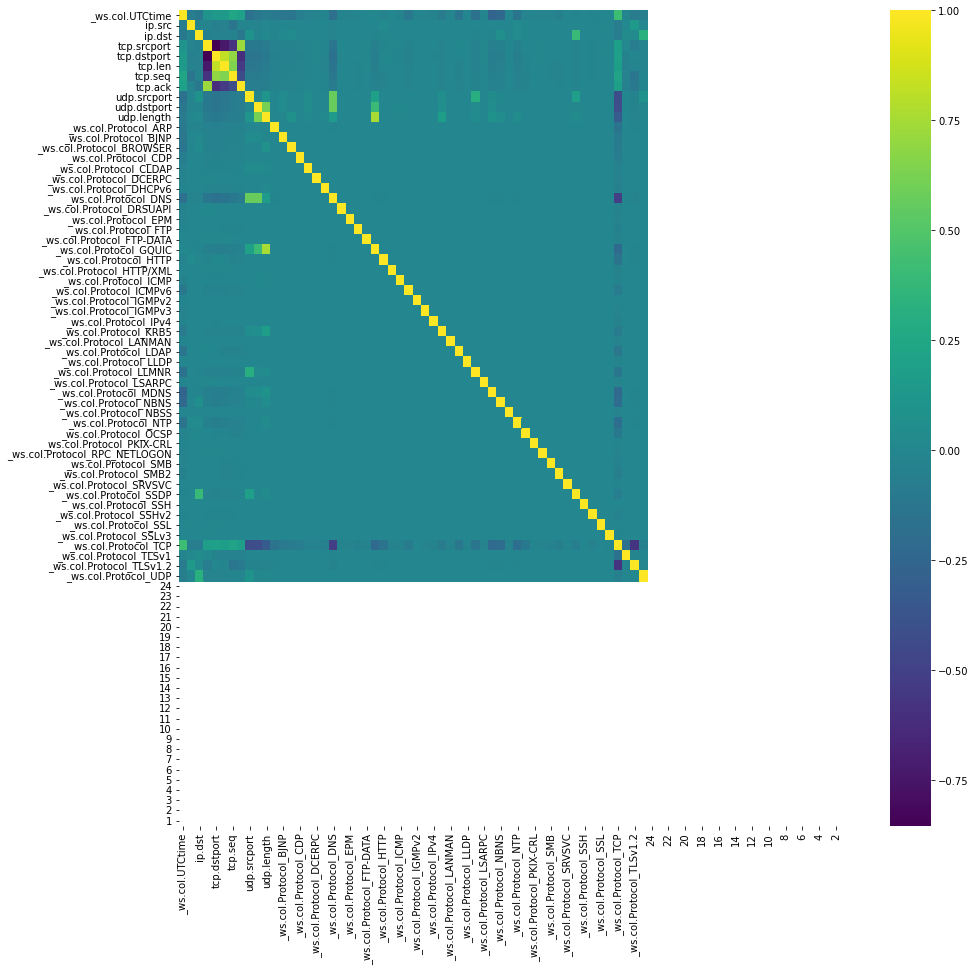

In [ ]:
# examining the correlation between different features
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(Train_data.corr(), cmap='viridis')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


PCA(n_components=0.8)


In [ ]:
#autoencoder을 위한 input 중 column의 개수를 80으로 고정, 80보다 작을 시 비어있는 행을 추가하여 input size를 맞춘다.

col_num = len(Train_data.columns)
fillup = 80 - col_num
i = 0
while i<fillup:
  a=fillup-i
  Train_data[a]=np.nan
  i += 1

Train_data=Train_data.fillna(0)

In [ ]:
# 시각적으로 진행도를 확인하기 위해 tqdm을 import
import tqdm

def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [ ]:
window_size, stride = 10, 10
windows_arr = get_windows(Train_data, window_size, stride)

100%|██████████| 100000/100000 [00:07<00:00, 14170.61it/s]


In [ ]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Auto Encoder

In [ ]:
K.clear_session()
# encoder model with stacked LSTM
          
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 80), dropout=0.2), LSTM(50, activation='selu', return_sequences=True), 
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True), 
                      TimeDistributed(Dense(80, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam',loss = 'mse', metrics=['accuracy'])
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                83400     
                                                                 
 decoder (Sequential)        (None, 10, 80)            62600     
                                                                 
Total params: 146,000
Trainable params: 146,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            51520     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 83,400
Trainable params: 83,400
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVector  (None, 10, 20)           0         
 )                                                               
                                      

(None, None)

이제 auto encoder를 이용해서 csv00번 파일로 train 해보자

In [ ]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
# epochs 늘리기
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=3, callbacks=[check_point])

Epoch 1/3
1249/1250 [============================>.] - ETA: 0s - loss: 0.6054 - accuracy: 0.2155
Epoch 1: val_loss improved from inf to 0.49715, saving model to autoencoder.h5
1250/1250 [==============================] - 52s 38ms/step - loss: 0.6050 - accuracy: 0.2155 - val_loss: 0.4971 - val_accuracy: 0.2248
Epoch 2/3
1249/1250 [============================>.] - ETA: 0s - loss: 0.5407 - accuracy: 0.2252
Epoch 2: val_loss improved from 0.49715 to 0.46916, saving model to autoencoder.h5
1250/1250 [==============================] - 49s 39ms/step - loss: 0.5409 - accuracy: 0.2252 - val_loss: 0.4692 - val_accuracy: 0.2311
Epoch 3/3
1249/1250 [============================>.] - ETA: 0s - loss: 0.5218 - accuracy: 0.2293
Epoch 3: val_loss improved from 0.46916 to 0.45711, saving model to autoencoder.h5
1250/1250 [==============================] - 47s 38ms/step - loss: 0.5215 - accuracy: 0.2293 - val_loss: 0.4571 - val_accuracy: 0.2352


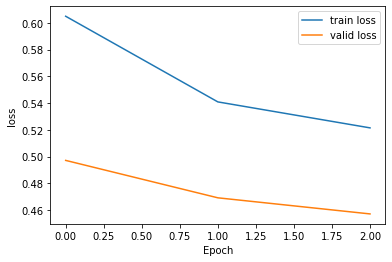

In [ ]:
#각 epoch에 따른 loss의 변화를 보여주는 그래프를 출력
#epoch가 늘어날수록 loss가 줄어든다는 것을 알 수 있다.

plt.plot(train_hist.history['loss'], label='train loss')
plt.plot(train_hist.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

최선의 모델을 autoencoder_loaded에 저장하고 앞으로 활용한다.

In [ ]:
# 가장 작은 loss를 보여준 모델을 저장한다.

autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5') 

Validation - data prepareing

In [ ]:
# autoencoder의 input은 80으로 고정되어있다.
# 따라서 input data의 column의 개수를 80으로 늘려 수를 맞춘다.

col_num = len(Valid_data.columns)
fillup = 80 - col_num

i = 0
while i<fillup:
  a=fillup-i
  Valid_data[a]=np.nan
  i += 1

Valid_data=Valid_data.fillna(0)
Valid_data.head()

,_ws.col.UTCtime,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.seq,tcp.ack,udp.srcport,udp.dstport,...,10,9,8,7,6,5,4,3,2,1
0,600002563.0,2.222368e+10,1.089204e+08,60610.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,600002665.0,1.159320e+08,1.089204e+08,53155.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,600002666.0,1.159320e+08,1.089204e+08,53155.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,600002679.0,1.089204e+08,2.222368e+10,80.0,60610.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,600002742.0,1.089204e+08,1.159320e+08,80.0,53155.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
valid_windows = get_windows(Valid_data, window_size=10, stride=10)

100%|██████████| 199005/199005 [00:37<00:00, 5271.52it/s]


In [ ]:
valid_windows_pred = autoencoder_loaded.predict(valid_windows)

validation을 위한 prediction이 완료되었으므로 이제 모델이 얼마나 정확한지 확인해보자.

In [ ]:
# mse를 계산하기 위해 미리 array를 제곱하는 함수를 정의

from sklearn import metrics
import numpy as np

def SquareList(L):
    if type(L) is list:
        return [SquareList(x) for x in L]
    else:
        return L**2

In [ ]:
# 차이의 제곱의 평균을 구해 mse에 저장한다.

A = (valid_windows)-(valid_windows_pred)
B = SquareList(A)
C = B.mean(axis=1)
mse = np.concatenate(C) ##mse를 1차원으로

len(mse) #이후 이에 맞는 normal 파일을 형성하기 위해 계산

15920400

In [ ]:
## 우리는 전부 정답인(14번파일)을 사용중이기 때문에 따로 normal 파일을 생성해 사용한다.

normal= np.full((1, len(mse)), 1)
normal=np.concatenate(normal)
normal

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
error_df = pd.DataFrame({'Reconstruction_error':mse, 'True_class':normal}) 
error_df.head()

,Reconstruction_error,True_class
0,3.604348e+17,1
1,4.939966e+19,1
2,4.940277e+19,1
3,9.487260e+10,1
4,1.398857e+11,1


In [ ]:
## precision = 정밀도
## recall = 재현율

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

In [ ]:
# 최적의 threshold일 때의 precision, recall을 프린트
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  1.0 , recall:  1.0
threshold:  2.0900987690048584e-06


malicious 파일을 이용해 test

In [ ]:
#코드의 맨 처음에 정해둔 PATH를 따라 test_df에 데이터 저장
Test_d = pd.read_csv('/content/drive/MyDrive/network_malicious_training_set.csv')
#header 추가
Test_d.columns=["_ws.col.UTCtime","_ws.col.Protocol","ip.src", "ip.dst", "tcp.srcport", "tcp.dstport", "tcp.len", "tcp.seq", "tcp.ack", "udp.srcport", "udp.dstport", "udp.length"]
Test_data=preprocessing(Test_d)

,_ws.col.UTCtime,_ws.col.Protocol,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.seq,tcp.ack,udp.srcport,...,http.request.method,http.request.uri,http.user_agent,http.connection,http.host,http.response.code,http.server,http.content_type,http.content_length,http.cache_control
0,12:17:53,TCP,192.168.10.50,172.16.0.1,21,52108,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12:17:53,FTP,192.168.10.50,172.16.0.1,21,52108,20,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12:17:53,TCP,172.16.0.1,192.168.10.50,52108,21,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12:17:53,TCP,172.16.0.1,192.168.10.50,52108,21,0,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12:17:53,TCP,172.16.0.1,192.168.10.50,52108,21,0,1,21,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# autoencoder의 input은 80으로 고정되어있다.
# 따라서 input data의 column의 개수를 80으로 늘려 수를 맞춘다.

col_num = len(Test_data.columns)
fillup = 80 - col_num

i = 0
while i<fillup:
  a=fillup-i
  Test_data[a]=np.nan
  i += 1

Test_data=Test_data.fillna(0)

In [ ]:
pred_windows = get_windows(Test_data, window_size=10, stride=10)

100%|██████████| 208/208 [00:00<00:00, 4875.54it/s]


In [ ]:
pred_windows_pred = autoencoder_loaded.predict(pred_windows)

In [ ]:
#test/validation과 마찬가지의 방법으로 mse를 계산

A = (pred_windows)-(pred_windows_pred)
B = SquareList(A)
C = B.mean(axis=1)
mse = np.concatenate(C) ##mse를 1차원으로

len(mse) #이후 이에 맞는 normal 파일을 형성하기 위해 계산

16640

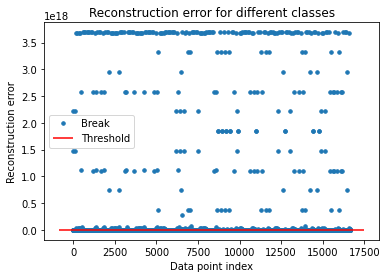

In [ ]:
#Autoencoder 모델을 통해 data를 예측 후 재구성 손실(reconstruction_error)을 계산, 그 후 위에서 찾은 threshold를 적용하여 attack인지 아닌지 구분

attack= np.full((1, len(mse)), 1)
attack=np.concatenate(attack)
attack

error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': attack})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

이제 test 파일을 불러와 실제 예측을 해보자

In [ ]:
#코드의 맨 처음에 정해둔 PATH를 따라 test_df에 데이터 저장
#data_t = pd.read_csv(TEST_DATA_PATH)
#data_t.head()

In [ ]:
import csv
import pandas as pd

Predict_data=pd.read_csv('/content/drive/MyDrive/정시보 test 해야하는 파일/network_test_dataset.csv',usecols=[x for x in range(12)],low_memory=False)

#header 추가
Predict_data.columns=["_ws.col.UTCtime","_ws.col.Protocol","ip.src", "ip.dst", "tcp.srcport", "tcp.dstport", "tcp.len", "tcp.seq", "tcp.ack", "udp.srcport", "udp.dstport", "udp.length"]

Predict_data.head()
Predict_data=preprocessing(Predict_data)

,_ws.col.UTCtime,_ws.col.Protocol,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.seq,tcp.ack,udp.srcport,udp.dstport,udp.length
0,16:59:13.353477,TCP,192.168.10.9,34.210.245.93,4904.0,443.0,0.0,1286.0,9732.0,NaN,NaN,NaN
1,17:35:26.499486,TCP,52.22.149.232,192.168.10.5,443.0,65467.0,0.0,5612.0,830.0,NaN,NaN,NaN
2,18:03:25.142466,TCP,192.168.10.19,172.217.6.194,46396.0,443.0,0.0,1058.0,5010.0,NaN,NaN,NaN
3,15:24:35.751838,TCP,192.168.10.5,199.244.49.16,63014.0,443.0,0.0,1958.0,12426.0,NaN,NaN,NaN
4,18:58:43.611761,TLSv1.2,50.116.194.21,192.168.10.5,443.0,51068.0,1460.0,1.0,189.0,NaN,NaN,NaN


In [ ]:
# autoencoder의 input은 80으로 고정되어있다.
# 따라서 input data의 column의 개수를 80으로 늘려 수를 맞춘다.

col_num = len(Predict_data.columns)
fillup = 80 - col_num

i = 0
while i<fillup:
  a=fillup-i
  Predict_data[a]=np.nan
  i += 1

data_t=Predict_data.fillna(0)
data_t.head()


,_ws.col.UTCtime,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.len,tcp.seq,tcp.ack,udp.srcport,udp.dstport,...,10,9,8,7,6,5,4,3,2,1
0,600002563.0,2.222368e+10,1.089204e+08,60610.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,600002665.0,1.159320e+08,1.089204e+08,53155.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,600002666.0,1.159320e+08,1.089204e+08,53155.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,600002679.0,1.089204e+08,2.222368e+10,80.0,60610.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,600002742.0,1.089204e+08,1.159320e+08,80.0,53155.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_windows = get_windows(data_t, window_size=10, stride=10)

100%|██████████| 199005/199005 [00:38<00:00, 5176.53it/s]


In [ ]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

In [ ]:
def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, 80])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [ ]:
prod_recon_errors = get_recon_erros(test_windows, test_windows_pred)
prod_recon_errors = np.array(prod_recon_errors).reshape(-1, 1)

array([[4.9435628e+09],
       [4.9429985e+09],
       [4.9406264e+09],
       ...,
       [2.5575347e+09],
       [2.5622892e+09],
       [2.5629445e+09]], dtype=float32)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler_prod = MinMaxScaler()
prod_anomaly_scores = mm_scaler_prod.fit_transform(prod_recon_errors).flatten()

array([0.01864454, 0.01864211, 0.01863191, ..., 0.00837908, 0.00839953,
       0.00840235], dtype=float32)

In [ ]:
#threshold를 0.9로 설정
threshold=0.9
prod_anomaly_indicator = (prod_anomaly_scores>threshold).astype(np.int32)


In [ ]:
prod_anomaly_indicator
# 이게 attack으로 판명되는 애들을 데리고 있음. 얘의 인덱스 번호 뽑아서 사용하자
# 인덱스 뽑고 나면 data_t에서 그 인덱스 정보 쫙다 불러오게 시키고
# 필요한 5가지의 정보는 걍 손으로 골라서 쓰자

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


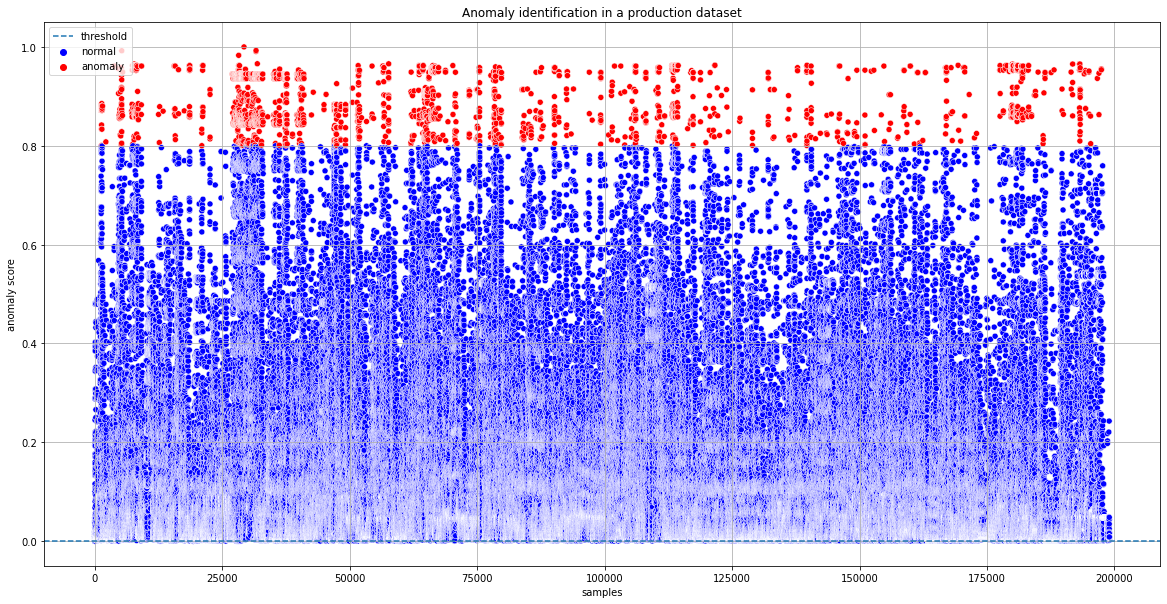

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(prod_anomaly_scores)), y= prod_anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in prod_anomaly_indicator], 
                palette=['blue', 'red'], legend='full')
plt.axhline(y = threshold_fixed, linestyle='--', label='threshold')
plt.title('Anomaly identification in a production dataset')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
data_test=pd.read_csv('/content/drive/MyDrive/정시보 test 해야하는 파일/network_test_dataset.csv',usecols=[x for x in range(12)],low_memory=False)

#header 추가
data_test.columns=["_ws.col.UTCtime","_ws.col.Protocol","ip.src", "ip.dst", "tcp.srcport", "tcp.dstport", "tcp.len", "tcp.seq", "tcp.ack", "udp.srcport", "udp.dstport", "udp.length"]

anomaly_index=np.where(prod_anomaly_indicator>0)
anomaly_row = data_test.loc[anomaly_index]
anomaly_row